# Yolo Detection 구현 : bus / trcuk detection

## 데이터셋 구축

### 캐글 데이터 받아오기

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

import torchvision
from torchvision.utils import make_grid

import torchvision.transforms as transforms
import os
import numpy as np
import pandas as pd
import utils
import matplotlib.pyplot as plt
import cv2
import json
import random
import albumentations as A
import shutil

from albumentations.pytorch import ToTensorV2
from collections import defaultdict
from time import time
from ipywidgets import interact
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval

import warnings
warnings.filterwarnings(action='ignore')

In [3]:
!pip install kaggle --upgrade

In [4]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"seonyong","key":"15cdbf608ae7dcc43e31d8ac3e790795"}'}

In [5]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
# Permission Warning이 발생하지 않도록 해줍니다.
!chmod 600 ~/.kaggle/kaggle.json

In [6]:
!mkdir data/
%cd data

/content/data


In [7]:
!kaggle datasets download -d sixhky/open-images-bus-trucks

 94% 345M/367M [00:03<00:00, 125MB/s]
100% 367M/367M [00:03<00:00, 112MB/s]


In [8]:
!unzip -qq '/content/data/open-images-bus-trucks.zip'

### 데이터 확인

In [9]:
data_dir  = '/content/data/images'

In [10]:
# 데이터 전체 수
data_len = os.listdir(data_dir + '/images')
len(data_len)

15225

In [11]:
# x, y 좌표는 정규화 -> 원래 좌표 필요 -> yolo 포멧 맞추기
df = pd.read_csv('/content/data/df.csv')
df = df.loc[:, ['ImageID', 'LabelName', 'XMin', 'XMax', 'YMin', 'YMax']]
df.head()

,ImageID,LabelName,XMin,XMax,YMin,YMax
0,0000599864fd15b3,Bus,0.343750,0.908750,0.156162,0.650047
1,00006bdb1eb5cd74,Truck,0.276667,0.697500,0.141604,0.437343
2,00006bdb1eb5cd74,Truck,0.702500,0.999167,0.204261,0.409774
3,00010bf498b64bab,Bus,0.156250,0.371250,0.269188,0.705228
4,00013f14dd4e168f,Bus,0.287500,0.999375,0.194184,0.999062


In [12]:
# 데이터셋 비율 - 8:1:1
split_ratio = [0.8, 0.1, 0.1]
train_len = int(len(data_len) * split_ratio[0])
val_len = int(len(data_len) * split_ratio[1])
test_len = len(data_len) - train_len - val_len
print('{}, {}, {}'.format(train_len, val_len, test_len))

12180, 1522, 1523


In [13]:
# 데이터를 랜덤으로 섞고 길이에 따라서 데이터 나누기
data_list = (os.listdir(data_dir+'/images'))
random.shuffle(data_list)

train_img, val_img, test_img = [], [], []

for i in range(len(data_list)):
    if 0 <= i < train_len:
        train_img.append(data_list[i])
    elif train_len <= i < train_len + val_len:
        val_img.append(data_list[i])
    elif train_len + val_len <= i:
        test_img.append(data_list[i])

print('{}, {}, {}'.format(len(train_img), len(val_img), len(test_img)))

12180, 1522, 1523


In [14]:
!mkdir 'train' 'val' 'test'

In [15]:
# 8:1:1 비율로 각각의 폴더 안에 데이터 나누어 넣기
to_file_path = '/content/data/'
from_file_path = '/content/data/images/images/'

for idx, file_name in enumerate(os.listdir(from_file_path)):
    if 0 <= idx < train_len:
        shutil.copyfile(from_file_path + file_name, to_file_path + 'train/' + file_name)
    elif train_len <= idx < train_len + val_len:
        shutil.copyfile(from_file_path + file_name, to_file_path + 'val/' + file_name)
    elif train_len +  val_len <= idx:
        shutil.copyfile(from_file_path + file_name, to_file_path + 'test/' + file_name)

print('{}, {}, {}'.format(len(os.listdir(to_file_path+'train')), len(os.listdir(to_file_path+'val')), len(os.listdir(to_file_path+'test'))))

12180, 1522, 1523


In [16]:
print('{}, {}, {}'.format(len(os.listdir(to_file_path+'train')), len(os.listdir(to_file_path+'val')), len(os.listdir(to_file_path+'test'))))

12180, 1522, 1523


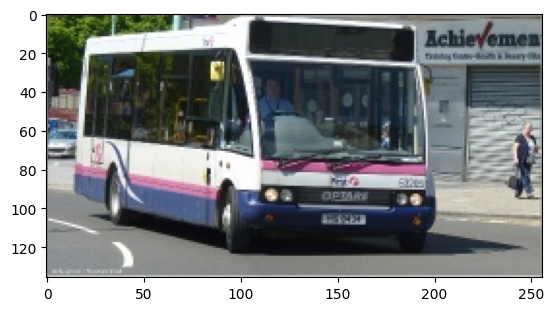

In [17]:
data_dir = '/content/data'

index = 205
file_name = os.listdir(data_dir + '/train')[index]
image = cv2.imread(os.path.join(data_dir, 'train', file_name))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.show()

In [18]:
image_id = file_name.split('.')[0]
image_id

'1695fbe72088832e'

In [19]:
# 바운딩 box는 하나가 아닐 수도 있다
meta_data = df[df['ImageID'] == image_id]
meta_data

,ImageID,LabelName,XMin,XMax,YMin,YMax
3119,1695fbe72088832e,Bus,0.055,0.78625,0.007051,0.913043


In [20]:
label = meta_data['LabelName'].values
label

array(['Bus'], dtype=object)

In [21]:
# Normalize -> 원본 크기로 변환해야 할 필요가 있다.
boxes = meta_data[['XMin', 'XMax', 'YMin', 'YMax']].values
print(boxes, type(boxes[0]))

[[0.055    0.78625  0.007051 0.913043]] <class 'numpy.ndarray'>


In [22]:
CLASS_NAME_TO_ID = {'Bus':0, 'Truck':1}
CLASS_NAME_TO_ID

{'Bus': 0, 'Truck': 1}

In [23]:
CLASS_ID_TO_NAME = {0: 'Bus', 1: 'Truck'}
CLASS_ID_TO_NAME

{0: 'Bus', 1: 'Truck'}

In [24]:
class_ids = [CLASS_NAME_TO_ID[id] for id in label]
class_ids

[0]

In [25]:
img_H, img_W, _ = image.shape

unnorm_bboxes = boxes.copy()
unnorm_bboxes[:, [1,2]] = unnorm_bboxes[:, [2,1]]
unnorm_bboxes[:, 2:4] -= unnorm_bboxes[:, 0:2]
unnorm_bboxes[:, 0:2] += (unnorm_bboxes[:, 2:4] / 2)
unnorm_bboxes[:, [0,2]] *= img_W
unnorm_bboxes[:, [1,3]] *= img_H

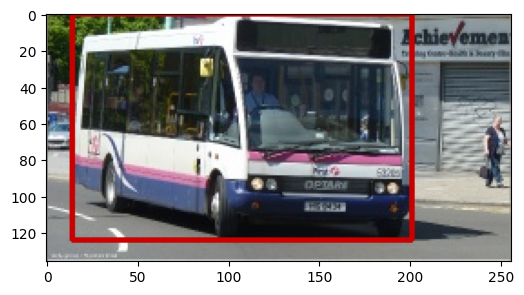

In [26]:
canvas = utils.visualize(image, unnorm_bboxes, class_ids)
plt.figure(figsize=(6,6))
plt.imshow(canvas)
plt.show()

In [27]:
image_files = os.listdir(data_dir + '/train')

In [28]:
@interact(index=(0, len(image_files)-1))
def show_sample(index=0):
    image_file = image_files[index]
    image_path = os.path.join('/content/data/train', image_file)
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    image_id = image_file.split('.')[0]
    meta_data = df[df['ImageID'] == image_id]
    cate_names = meta_data["LabelName"].values
    bboxes = meta_data[["XMin", "XMax", "YMin", "YMax"]].values

    img_H, img_W, _ = image.shape

    class_ids = [CLASS_NAME_TO_ID[cate_name] for cate_name in cate_names]
    unnorm_bboxes = bboxes.copy()
    unnorm_bboxes[:, [1,2]] = unnorm_bboxes[:, [2,1]]
    unnorm_bboxes[:, 2:4] -= unnorm_bboxes[:, 0:2]
    unnorm_bboxes[:, 0:2] += (unnorm_bboxes[:, 2:4] / 2)
    unnorm_bboxes[:, [0,2]] *= img_W
    unnorm_bboxes[:, [1,3]] *= img_H
    canvas = utils.visualize(image, unnorm_bboxes, class_ids)

    plt.figure(figsize=(6,6))
    plt.imshow(canvas)
    plt.axis('off')
    plt.show()
    print(canvas.shape)

interactive(children=(IntSlider(value=0, description='index', max=12179), Output()), _dom_classes=('widget-int…

### 연산을 위한 텐서 변환

1.   dataset
2.   dataloader

In [166]:
class MyDataset():
    def __init__(self, data_dir, phase, transform=None):
        self.data_dir = data_dir
        self.phase = phase
        self.df = pd.read_csv(os.path.join(self.data_dir, 'df.csv'))
        self.image_files = [fn for fn in os.listdir(os.path.join(self.data_dir, phase)) if fn.endswith('jpg')]
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, index):
        # iamge, class_id, bounding box(xc, yc, w, h) 형식
        filename, image = self.get_image(index)
        bboxes, class_ids = self.get_label(filename)

        if self.transform:
            transformed_data = transform(image=image, bboxes=bboxes, class_ids=class_ids)
            image = transformed_data['image']
            bboxes = np.array(transformed_data['bboxes'])
            class_ids = np.array(transformed_data['class_ids'])

        target = np.concatenate((bboxes, class_ids[:, np.newaxis]), axis=1)
        return image, target, filename

    def get_image(self, index):
        filename = self.image_files[index]
        image_path = os.path.join(self.data_dir, self.phase, filename)
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        return filename, image

    def get_label(self, filename):
        image_id = filename.split('.')[0]
        meta_data = self.df[self.df['ImageID'] == image_id]
        cate_names = meta_data['LabelName'].values
        class_ids = np.array([CLASS_NAME_TO_ID[cate_name] for cate_name in cate_names])

        # 'XMin', 'XMax', 'YMin', 'YMax' -> X.center, Y.center, X.w, Y.h
        bboxes = meta_data[['XMin', 'XMax', 'YMin', 'YMax']].values
        bboxes[:, [1, 2]] = bboxes[:, [2, 1]] # XMax, YMin 자리바꿈
        bboxes[:, 2:4] -= bboxes[:, 0:2] # XMax -> w, YMax -> h
        bboxes[:, 0:2] += bboxes[:, 2:4] / 2 # XMin -> x좌표 center, YMin -> y좌표 center
        return bboxes, class_ids

In [167]:
dataset = MyDataset(data_dir=data_dir, phase='train', transform=None)

In [168]:
image, target, filename = dataset[0]

In [169]:
image.shape

(144, 256, 3)

In [170]:
target

array([[0.4996875, 0.499444 , 0.999375 , 0.998888 , 0.       ]])

In [171]:
filename

'306f42759b9643c4.jpg'

In [172]:
@interact(index=(0, len(dataset)-1))
def show_sample(index=0):
    image, target, filename = dataset[index]
    img_H, img_W, _ = image.shape

    bboxes = target[:, 0:4]
    class_ids = target[:, 4]
    bboxes[:, [0,2]] *= img_W
    bboxes[:, [1,3]] *= img_H

    canvas = utils.visualize(image, bboxes, class_ids)
    plt.figure(figsize=(6,6))
    plt.imshow(canvas)
    plt.axis('off')
    plt.show()

interactive(children=(IntSlider(value=0, description='index', max=12179), Output()), _dom_classes=('widget-int…

In [173]:
 IMAGE_SIZE = 448

 transform = A.Compose([
                        A.Resize(height=IMAGE_SIZE, width=IMAGE_SIZE),
                        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
                        ToTensorV2()
                        ],
                       bbox_params=A.BboxParams(format='yolo', label_fields=['class_ids'])
)

In [174]:
dataset = MyDataset(data_dir=data_dir, phase='train', transform=transform)

In [175]:
image, target, filename = dataset[0]

In [176]:
image.shape

torch.Size([3, 448, 448])

In [177]:
target

array([[0.4996875, 0.499444 , 0.999375 , 0.998888 , 0.       ]])

In [178]:
filename

'306f42759b9643c4.jpg'

In [179]:
@interact(index=(0, len(dataset)-1))
def show_sample(index=0):
    image, target, filename = dataset[index]
    _, img_H, img_W = image.shape
    print(image.shape)

    bboxes = target[:, 0:4]
    class_ids = target[:, 4]
    bboxes[:, [0,2]] *= img_W
    bboxes[:, [1,3]] *= img_H

    np_image = make_grid(image, normalize=True).cpu().permute(1,2,0).numpy()
    canvas = utils.visualize(np_image, bboxes, class_ids)
    plt.figure(figsize=(6,6))
    plt.imshow(canvas)
    plt.show()

interactive(children=(IntSlider(value=0, description='index', max=12179), Output()), _dom_classes=('widget-int…

In [180]:
def collate_fn(batch):
    image_list = []
    target_list = []
    filename_list = []

    for i, t, f in batch:
        image_list.append(i)
        target_list.append(t)
        filename_list.append(f)

    return torch.stack(image_list, dim=0), target_list, filename_list

In [181]:
def build_dataloader(data_dir, batch_size, image_size):
    transform = A.Compose(
        [
            A.Resize(height=image_size, width=image_size),
            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
            ToTensorV2()
        ],
        bbox_params=A.BboxParams(format='yolo', label_fields=['class_ids'])
    )

    dataloaders = {}

    trainset = MyDataset(data_dir, phase='train', transform=transform)
    valset = MyDataset(data_dir, phase='val', transform=transform)
    testset = MyDataset(data_dir, phase='test', transform=transform)

    dataloaders['train'] = DataLoader(trainset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
    dataloaders['val'] = DataLoader(valset, batch_size=1, shuffle=False, collate_fn=collate_fn)
    dataloaders['test'] = DataLoader(testset, batch_size=1, shuffle=False, collate_fn=collate_fn)

    return dataloaders

In [182]:
data_dir = '/content/data'
BATCH_SIZE = 4
IMAGE_SIZE = 448

dataloaders = build_dataloader(data_dir, BATCH_SIZE, IMAGE_SIZE)

In [183]:
for phase in ["train", "val", "test"]:
    for index, batch in enumerate(dataloaders[phase]):
        images = batch[0]
        targets = batch[1]
        filenames = batch[2]
        print(f'-------------{phase}--------------')
        print(images.shape)
        print(targets)
        print(filename)
        if index == 0:
            break

-------------train--------------
torch.Size([4, 3, 448, 448])
[array([[0.0787585, 0.7908465, 0.118301 , 0.097441 , 1.       ],
       [0.2379085, 0.805118 , 0.250981 , 0.21063  , 1.       ],
       [0.607843 , 0.648622 , 0.671896 , 0.551182 , 1.       ]]), array([[0.09375  , 0.642857 , 0.18375  , 0.572362 , 1.       ],
       [0.5065625, 0.487395 , 0.539375 , 0.849674 , 1.       ]]), array([[0.477955 , 0.4803125, 0.072232 , 0.043125 , 0.       ]]), array([[0.1221875, 0.609608 , 0.185625 , 0.267724 , 1.       ],
       [0.1234375, 0.526119 , 0.216875 , 0.375    , 0.       ],
       [0.475    , 0.5340485, 0.515    , 0.497201 , 0.       ]])]
306f42759b9643c4.jpg
-------------val--------------
torch.Size([1, 3, 448, 448])
[array([[0.3859375, 0.5233335, 0.771875 , 0.571667 , 0.       ]])]
306f42759b9643c4.jpg
-------------test--------------
torch.Size([1, 3, 448, 448])
[array([[0.3646875, 0.790417 , 0.725625 , 0.3675   , 1.       ]])]
306f42759b9643c4.jpg


## YOLOv1 아키텍처 구현

In [47]:
# resnet18에서 layers 부분만 backbone, (avgpool, fc)는 사용 X
resnet18 = torchvision.models.resnet18(pretrained=False)
resnet18

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [48]:
layers = [layer for layer in resnet18.children()]
layers, len(layers)

([Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False),
  BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
  ReLU(inplace=True),
  MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False),
  Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), s

In [49]:
test_backbone = nn.Sequential(*layers[:-2])

x = torch.randn(1, 3, IMAGE_SIZE, IMAGE_SIZE)
out = test_backbone(x)
out.shape

torch.Size([1, 512, 14, 14])

In [50]:
class YOLO_RESNET(nn.Module):
    def __init__(self, num_classes):
        super(YOLO_RESNET, self).__init__()
        num_classes = num_classes
        num_bboxes = 2
        grid_size = 7

        resnet18 = torchvision.models.resnet18(pretrained=True)
        layers = [layer for layer in resnet18.children()]

        self.backbone = nn.Sequential(*layers[:-2])
        self.neck = nn.Sequential(
                                nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=1, padding=0, bias=False),
                                nn.BatchNorm2d(1024),
                                nn.ReLU(inplace=True),

                                nn.Conv2d(in_channels=1024, out_channels=1024, kernel_size=3, padding=1, bias=False),
                                nn.BatchNorm2d(1024),
                                nn.ReLU(inplace=True),

                                nn.Conv2d(in_channels=1024, out_channels=1024, kernel_size=3, padding=1, bias=False),
                                nn.BatchNorm2d(1024),
                                nn.ReLU(inplace=True),

                                nn.Conv2d(in_channels=1024, out_channels=1024, kernel_size=3, padding=1, bias=False),
                                nn.BatchNorm2d(1024),
                                nn.ReLU(inplace=True),
        )
        self.head = nn.Sequential(
                                nn.Conv2d(in_channels=1024, out_channels=(4+1)*num_bboxes+num_classes, kernel_size=1, padding=0, bias=False),# yolo output depth
                                nn.AdaptiveAvgPool2d(output_size=(grid_size, grid_size))
        )

    def forward(self, x):
        out = self.backbone(x)
        out = self.neck(out)
        out = self.head(out) # (batch, 3, 448, 448) -> (batch, 12, 7, 7)

        return out

In [51]:
NUM_CLASSES = 2
model = YOLO_RESNET(NUM_CLASSES)
model

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 115MB/s]


YOLO_RESNET(
  (backbone): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=

In [52]:
x = torch.randn(1, 3, 448, 448)
out = model(x)
out.shape

torch.Size([1, 12, 7, 7])

In [53]:
BATCH_SIZE = 4
model = YOLO_RESNET(num_classes=NUM_CLASSES)

for index, batch in enumerate(dataloaders['train']):
    images = batch[0]
    targets = batch[1]
    filenames = batch[2]

    predictions = model(images)

    print(f'input shape: {images.shape} | output shape: {predictions.shape}')

    if index == 5:
        break

input shape: torch.Size([4, 3, 448, 448]) | output shape: torch.Size([4, 12, 7, 7])
input shape: torch.Size([4, 3, 448, 448]) | output shape: torch.Size([4, 12, 7, 7])
input shape: torch.Size([4, 3, 448, 448]) | output shape: torch.Size([4, 12, 7, 7])
input shape: torch.Size([4, 3, 448, 448]) | output shape: torch.Size([4, 12, 7, 7])
input shape: torch.Size([4, 3, 448, 448]) | output shape: torch.Size([4, 12, 7, 7])
input shape: torch.Size([4, 3, 448, 448]) | output shape: torch.Size([4, 12, 7, 7])


## YOLO Loss Function 구현

### ground truth mapping

In [54]:
num_classes = 2
grid_size = 7
device = 'cpu'

In [55]:
def build_target_grid(target):# target : (C, H, W)
    # target -> 7(grid_size) * 7(grid_size) * 7(depth : [(1:object + 4:bounding boxes) + 2:class] -> (ex)[1, xc, yc, w, h, 1, 0])

    target_grid = torch.zeros((1+4+num_classes, grid_size, grid_size), device=device)

    for gt in target:
        xc, yc, w, h, cls_id = gt
        xn = (xc % (1/grid_size))
        yn = (yc % (1/grid_size))
        cls_id = int(cls_id)

        i_grid = int(xc * grid_size)
        j_grid = int(yc * grid_size)
        target_grid[0, j_grid, i_grid] = 1
        target_grid[1:5, j_grid, i_grid] = torch.Tensor([xn,yn,w,h])
        target_grid[5+cls_id, j_grid, i_grid] = 1

    return target_grid

In [56]:
def build_batch_target_grid(targets):
    target_grid_batch = torch.stack([build_target_grid(target) for target in targets], dim=0) # (B, C, H, W) -> (B, 7, 7, 7)
    return target_grid_batch

In [57]:
targets

[array([[0.49    , 0.548969, 0.71375 , 0.780412, 0.      ]]),
 array([[0.4059375, 0.7479165, 0.698125 , 0.470833 , 1.       ]]),
 array([[0.1359375, 0.8914065, 0.237499 , 0.198437 , 1.       ],
        [0.180469 , 0.625781 , 0.360938 , 0.154688 , 1.       ],
        [0.1218755, 0.5234375, 0.046875 , 0.037501 , 1.       ],
        [0.2195315, 0.526563 , 0.054687 , 0.03125  , 1.       ],
        [0.291406 , 0.807813 , 0.145312 , 0.05625  , 1.       ],
        [0.3828125, 0.5171875, 0.100001 , 0.040625 , 1.       ]]),
 array([[0.4578125, 0.4729165, 0.328125 , 0.433333 , 1.       ]])]

In [58]:
len(targets)

4

In [59]:
ground_truths = build_batch_target_grid(targets)

print(ground_truths.shape)
print(ground_truths[0])

torch.Size([4, 7, 7, 7])
tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0614, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000,

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000], objectness
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0974, 0.0000, 0.0000, 0.0000, 0.0000], xn
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0373, 0.0000, 0.0000, 0.0000, 0.0000], yn
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.5713, 0.0000, 0.0000, 0.0000, 0.0000], w
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.7183, 0.0000, 0.0000, 0.0000, 0.0000], h
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000], bus(1, 0)
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000], -> bux o
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000], trcuk(0, 1)
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000], -> truck x
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]]])




### IoU
- xn, yn, w, h -> xmin, ymin, xmax, ymax

In [60]:
def get_IoU(cbox1, cbox2):
    box1 = xywh_to_xyxy(cbox1)
    box2 = xywh_to_xyxy(cbox2)

    # 교집합 부분
    x1 = torch.max(box1[:, 0, ...], box2[:, 0, ...])
    y1 = torch.max(box1[:, 1, ...], box2[:, 1, ...])
    x2 = torch.min(box1[:, 2, ...], box2[:, 2, ...])
    y2 = torch.min(box1[:, 3, ...], box2[:, 3, ...])

    intersection = (x2 - x1).clamp(min=0) * (y2 - y1).clamp(min=0)

    # 합집합 부분
    union = abs(cbox1[:, 2, ...] * cbox1[:, 3, ...]) + abs(cbox2[:, 2, ...] * cbox2[:, 3, ...]) - intersection # (w * h) + (w * h) - intersection = union

    # 7*7*7 dimension shape 유지하면서 iou 반환
    intersection[intersection.gt(0)] = intersection[intersection.gt(0)] / union[intersection.gt(0)]

    return intersection

In [61]:
def xywh_to_xyxy(cbox):
    # cbox : (xn, yn, w, h) -> offset box : (xc, yc, w, h) -> box : (xmin, ymin, xmax, ymax)

    # 1: cbox : (xn, yn, w, h) -> offset box : (xc, yc, w, h)
    num_batch, _, grid_size, grid_size = cbox.shape
    xy_normed_grid = generate_xy_normed_size(grid_size=grid_size)
    xcyc = cbox[:, 0:2, ...] + xy_normed_grid.tile(num_batch, 1, 1, 1)

    # 2 : offset box : (xc, yc, w, h) -> box : (xmin, ymin, xmax, ymax)
    wh = cbox[:, 2:4, ...]
    x1y1 = xcyc - (wh/2)
    x2y2 = xcyc + (wh/2)

    return torch.cat([x1y1, x2y2], dim=1)

In [62]:
def generate_xy_normed_size(grid_size):
     y_offset, x_offset = torch.meshgrid(torch.arange(grid_size), torch.arange(grid_size))
     xy_grid = torch.stack([x_offset, y_offset], dim=0)
     xy_normed_grid = xy_grid / grid_size

     return xy_normed_grid

In [63]:
xy_normed_grid = generate_xy_normed_size(grid_size)
xy_normed_grid

tensor([[[0.0000, 0.1429, 0.2857, 0.4286, 0.5714, 0.7143, 0.8571],
         [0.0000, 0.1429, 0.2857, 0.4286, 0.5714, 0.7143, 0.8571],
         [0.0000, 0.1429, 0.2857, 0.4286, 0.5714, 0.7143, 0.8571],
         [0.0000, 0.1429, 0.2857, 0.4286, 0.5714, 0.7143, 0.8571],
         [0.0000, 0.1429, 0.2857, 0.4286, 0.5714, 0.7143, 0.8571],
         [0.0000, 0.1429, 0.2857, 0.4286, 0.5714, 0.7143, 0.8571],
         [0.0000, 0.1429, 0.2857, 0.4286, 0.5714, 0.7143, 0.8571]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429],
         [0.2857, 0.2857, 0.2857, 0.2857, 0.2857, 0.2857, 0.2857],
         [0.4286, 0.4286, 0.4286, 0.4286, 0.4286, 0.4286, 0.4286],
         [0.5714, 0.5714, 0.5714, 0.5714, 0.5714, 0.5714, 0.5714],
         [0.7143, 0.7143, 0.7143, 0.7143, 0.7143, 0.7143, 0.7143],
         [0.8571, 0.8571, 0.8571, 0.8571, 0.8571, 0.8571, 0.8571]]])

- Loss Function

In [64]:
class YOLO_LOSS():
    def __init__(self, num_classes, device, lambda_coord=5., lambda_noobj=0.5):
        self.num_classes = num_classes
        self.device = device
        self.grid_size = 7
        self.lambda_coord = lambda_coord
        self.lambda_noobj = lambda_noobj
        self.mse_loss = nn.MSELoss(reduction="sum")

    def __call__(self, predictions, targets):
        self.batch_size, _, _, _ = predictions.shape
        groundtruths = self.build_batch_target_grid(targets)
        groundtruths = groundtruths.to(self.device)

        with torch.no_grad():
            iou1 = self.get_IoU(predictions[:, 1:5, ...], groundtruths[:, 1:5, ...])
            iou2 = self.get_IoU(predictions[:, 6:10, ...], groundtruths[:, 1:5, ...])

        ious = torch.stack([iou1, iou2], dim=1)
        max_iou, best_box = ious.max(dim=1, keepdim=True)
        max_iou = torch.cat([max_iou, max_iou], dim=1)
        best_box = torch.cat([best_box.eq(0), best_box.eq(1)], dim=1)

        predictions_ = predictions[:, :5*2, ...].reshape(self.batch_size, 2, 5, self.grid_size, self.grid_size)
        obj_pred = predictions_[:, :, 0, ...]
        xy_pred = predictions_[:, :, 1:3, ...]
        wh_pred = predictions_[:, :, 3:5, ...]
        cls_pred = predictions[:, 5*2:, ...]

        groundtruths_ = groundtruths[:, :5, ...].reshape(self.batch_size, 1, 5, self.grid_size, self.grid_size)
        obj_target = groundtruths_[:, :, 0, ...]
        xy_target = groundtruths_[:, :, 1:3, ...]
        wh_target= groundtruths_[:, :, 3:5, ...]
        cls_target = groundtruths[:, 5:, ...]

        positive = obj_target * best_box

        obj_loss = self.mse_loss(positive * obj_pred, positive * ious)
        noobj_loss = self.mse_loss((1 - positive) * obj_pred, ious*0)
        xy_loss = self.mse_loss(positive.unsqueeze(dim=2) * xy_pred, positive.unsqueeze(dim=2) * xy_target)
        wh_loss = self.mse_loss(positive.unsqueeze(dim=2) * (wh_pred.sign() * (wh_pred.abs() + 1e-8).sqrt()),
                                positive.unsqueeze(dim=2) * (wh_target + 1e-8).sqrt())
        cls_loss = self.mse_loss(obj_target * cls_pred, cls_target)

        obj_loss /= self.batch_size
        noobj_loss /= self.batch_size
        bbox_loss = (xy_loss+wh_loss) / self.batch_size
        cls_loss /= self.batch_size

        total_loss = obj_loss + self.lambda_noobj*noobj_loss + self.lambda_coord*bbox_loss + cls_loss
        return total_loss, (obj_loss.item(), noobj_loss.item(), bbox_loss.item(), cls_loss.item())

    def build_target_grid(self, target):
        target_grid = torch.zeros((1+4+self.num_classes, self.grid_size, self.grid_size), device=self.device)

        for gt in target:
            xc, yc, w, h, cls_id = gt
            xn = (xc % (1/self.grid_size))
            yn = (yc % (1/self.grid_size))
            cls_id = int(cls_id)

            i_grid = int(xc * self.grid_size)
            j_grid = int(yc * self.grid_size)
            target_grid[0, j_grid, i_grid] = 1
            target_grid[1:5, j_grid, i_grid] = torch.Tensor([xn,yn,w,h])
            target_grid[5+cls_id, j_grid, i_grid] = 1

        return target_grid

    def build_batch_target_grid(self, targets):
        target_grid_batch = torch.stack([self.build_target_grid(target) for target in targets], dim=0)
        return target_grid_batch

    def get_IoU(self, cbox1, cbox2):
        box1 = self.xywh_to_xyxy(cbox1)
        box2 = self.xywh_to_xyxy(cbox2)

        x1 = torch.max(box1[:, 0, ...], box2[:, 0, ...])
        y1 = torch.max(box1[:, 1, ...], box2[:, 1, ...])
        x2 = torch.min(box1[:, 2, ...], box2[:, 2, ...])
        y2 = torch.min(box1[:, 3, ...], box2[:, 3, ...])

        intersection = (x2-x1).clamp(min=0) * (y2-y1).clamp(min=0)
        union = abs(cbox1[:, 2, ...]*cbox1[:, 3, ...]) + \
                abs(cbox2[:, 2, ...]*cbox2[:, 3, ...]) - intersection

        intersection[intersection.gt(0)] = intersection[intersection.gt(0)] / union[intersection.gt(0)]
        return intersection

    def generate_xy_normed_grid(self):
        y_offset, x_offset = torch.meshgrid(torch.arange(self.grid_size), torch.arange(self.grid_size))
        xy_grid = torch.stack([x_offset, y_offset], dim=0)
        xy_normed_grid = xy_grid / self.grid_size
        return xy_normed_grid.to(self.device)

    def xywh_to_xyxy(self, bboxes):
        xy_normed_grid = self.generate_xy_normed_grid()
        xcyc = bboxes[:,0:2,...] + xy_normed_grid.tile(self.batch_size, 1,1,1)
        wh = bboxes[:,2:4,...]
        x1y1 = xcyc - (wh/2)
        x2y2 = xcyc + (wh/2)
        return torch.cat([x1y1, x2y2], dim=1)

In [70]:
data_dir = '/content/data'
is_cuda = True

BATCH_SIZE = 2
DEVICE = torch.device('cuda' if torch.cuda.is_available and is_cuda else 'cpu')

trainset = MyDataset(data_dir=data_dir, phase="train", transform=transform)
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
model = YOLO_RESNET(num_classes=NUM_CLASSES).to(DEVICE)
criterion = YOLO_LOSS(num_classes=NUM_CLASSES, device=DEVICE)
optimizer = torch.optim.SGD(model.parameters(), lr=0.0001, weight_decay=5e-4)

for index, batch in enumerate(trainloader):
    images = batch[0].to(DEVICE)
    targets = batch[1]
    filenames = batch[2]

    predictions = model(images)
    loss, (obj_loss, noobj_loss, bbox_loss, cls_loss) = criterion(predictions, targets)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if index % 1 == 0:
        print(loss, '\t|', obj_loss, '\t|',  noobj_loss, '\t|',  bbox_loss, '\t|',  cls_loss)

    if index == 10:
        break

tensor(18.3310, device='cuda:0', grad_fn=<AddBackward0>) 	| 0.2829308807849884 	| 21.297927856445312 	| 0.9635674953460693 	| 2.5812501907348633
tensor(13.4437, device='cuda:0', grad_fn=<AddBackward0>) 	| 0.031660206615924835 	| 5.804296493530273 	| 1.7170668840408325 	| 1.9245750904083252
tensor(8.7808, device='cuda:0', grad_fn=<AddBackward0>) 	| 0.21928678452968597 	| 5.753932952880859 	| 0.8120102286338806 	| 1.6245250701904297
tensor(9.5162, device='cuda:0', grad_fn=<AddBackward0>) 	| 0.03912598267197609 	| 4.1108598709106445 	| 1.244024634361267 	| 1.2015396356582642
tensor(6.1192, device='cuda:0', grad_fn=<AddBackward0>) 	| 0.11806434392929077 	| 5.762520790100098 	| 0.412137508392334 	| 1.0592243671417236
tensor(10.1849, device='cuda:0', grad_fn=<AddBackward0>) 	| 0.11756742000579834 	| 4.268908977508545 	| 1.2976915836334229 	| 1.4444706439971924
tensor(6.5828, device='cuda:0', grad_fn=<AddBackward0>) 	| 0.05110161378979683 	| 5.608715534210205 	| 0.580843985080719 	| 0.8231291

## Training

In [76]:
def train_one_epoch(dataloaders, model, criterion, optimizer, device):
    train_loss = defaultdict(float)
    val_loss = defaultdict(float)

    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()
        else:
            model.eval()

        running_loss = defaultdict(float)
        for index, batch in enumerate(dataloaders[phase]):
            images = batch[0].to(device)
            targets = batch[1]
            filenames = batch[2]

            with torch.set_grad_enabled(phase == 'train'):
                predictions = model(images)
            loss, (obj_loss, noobj_loss, bbox_loss, cls_loss) = criterion(predictions, targets)

            if phase == 'train':
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                running_loss['total_loss'] += loss.item()
                running_loss['obj_loss'] += obj_loss
                running_loss['noobj_loss'] += noobj_loss
                running_loss['bbox_loss'] += bbox_loss
                running_loss['cls_loss'] += cls_loss

                train_loss['total_loss'] += loss.item()
                train_loss['obj_loss'] += obj_loss
                train_loss['noobj_loss'] += noobj_loss
                train_loss['bbox_loss'] += bbox_loss
                train_loss['cls_loss'] += cls_loss

                if index % VERBOSE_FREQ == 0:
                    text = f'iteration:[{index}/{len(dataloaders[phase])}] - '
                    for k, v in running_loss.items():
                        text += f'{k}: {v/VERBOSE_FREQ:.4f} '
                        running_loss[k] = 0
                    print(text)

            else:
                val_loss['total_loss'] += loss.item()
                val_loss['obj_loss'] += obj_loss
                val_loss['noobj_loss'] += noobj_loss
                val_loss['bbox_loss'] += bbox_loss
                val_loss['cls_loss'] += cls_loss

    for k in train_loss.keys():
        train_loss[k] /= len(dataloaders['train'])
        val_loss[k] /= len(dataloaders['val'])

    return train_loss, val_loss

In [77]:
data_dir = '/content/data'
is_cuda = True
NUM_CLASSES = 2
IMAGE_SIZE = 448
BATCH_SIZE = 12
VERBOSE_FREQ = 50
DEVICE = torch.device('cuda' if torch.cuda.is_available() and is_cuda else 'cpu')

dataloaders = build_dataloader(data_dir=data_dir, batch_size=BATCH_SIZE, image_size=IMAGE_SIZE)
model = YOLO_RESNET(num_classes=NUM_CLASSES)
model = model.to(DEVICE)
criterion = YOLO_LOSS(num_classes=NUM_CLASSES, device=DEVICE)
optimizer = torch.optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)

In [78]:
num_epochs = 30

train_losses = []
val_losses = []

for epoch in range(num_epochs):
    train_loss, val_loss = train_one_epoch(dataloaders, model, criterion, optimizer, DEVICE)
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f'{epoch+1}/{num_epochs} - train loss: {train_loss["total_loss"]:.4f} - val loss: {val_loss["total_loss"]:.4f}')
    print('=======================================')

    if (epoch+1) % 10 == 0:
        utils.save_model(model.state_dict(), f'model_{epoch+1}.pth')

iteration:[0/1015] - total_loss: 0.3982 obj_loss: 0.0035 noobj_loss: 0.1627 bbox_loss: 0.0585 cls_loss: 0.0210 
iteration:[50/1015] - total_loss: 7.1196 obj_loss: 0.1041 noobj_loss: 2.6033 bbox_loss: 0.9938 cls_loss: 0.7448 
iteration:[100/1015] - total_loss: 2.0318 obj_loss: 0.1715 noobj_loss: 0.6347 bbox_loss: 0.2103 cls_loss: 0.4917 
iteration:[150/1015] - total_loss: 1.4470 obj_loss: 0.2486 noobj_loss: 0.3391 bbox_loss: 0.1181 cls_loss: 0.4382 
iteration:[200/1015] - total_loss: 1.2632 obj_loss: 0.2844 noobj_loss: 0.2460 bbox_loss: 0.0858 cls_loss: 0.4267 
iteration:[250/1015] - total_loss: 1.2126 obj_loss: 0.3036 noobj_loss: 0.2033 bbox_loss: 0.0801 cls_loss: 0.4070 
iteration:[300/1015] - total_loss: 1.2432 obj_loss: 0.3175 noobj_loss: 0.2097 bbox_loss: 0.0810 cls_loss: 0.4159 
iteration:[350/1015] - total_loss: 1.0393 obj_loss: 0.3278 noobj_loss: 0.1973 bbox_loss: 0.0495 cls_loss: 0.3651 
iteration:[400/1015] - total_loss: 1.1494 obj_loss: 0.3224 noobj_loss: 0.1925 bbox_loss: 0.

In [143]:
t_loss = []
v_loss = []

for i in range(30):
    t_loss.append(train_losses[i]['total_loss'])
    v_loss.append(val_losses[i]['total_loss'])

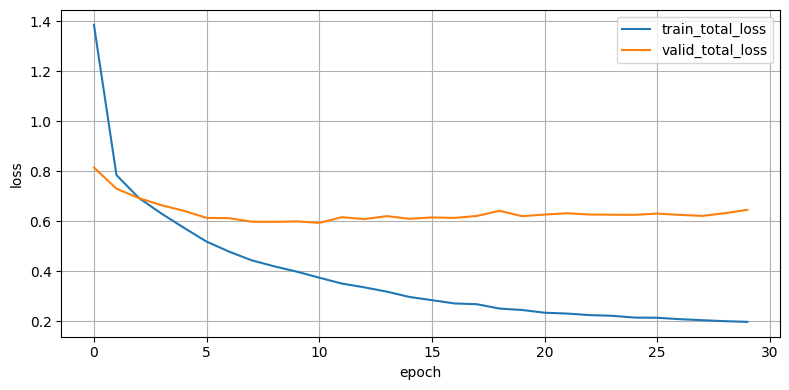

In [146]:
plt.figure(figsize=(8, 4))
plt.plot(t_loss, label = 'train_total_loss')
plt.plot(v_loss, label = 'valid_total_loss')

plt.xlabel("epoch")
plt.ylabel("loss")
plt.grid("on")
plt.legend(loc='upper right')
plt.tight_layout()

## TEST : NMS

In [184]:
def load_model(ckpt_path, num_classes, device):
    checkpoint = torch.load(ckpt_path, map_location=device)
    model = YOLO_RESNET(num_classes=num_classes)
    model.load_state_dict(checkpoint)
    model = model.to(device)
    model.eval()

    return model

In [148]:
transform = A.Compose([
    A.Resize(height=IMAGE_SIZE, width=IMAGE_SIZE),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

In [192]:
ckpt_path = '/content/data/trained_model/model_30.pth'
DEVICE = torch.device('cuda')
model = load_model(ckpt_path, NUM_CLASSES, DEVICE)

In [197]:
@torch.no_grad()
def model_predict(image, model, conf_threshold=0.3, iou_threshold=0.1):
    predictions = model(image)
    prediction = predictions.cpu().detach().squeeze(dim=0)

    grid_size = prediction.shape[-1]
    y_grid, x_grid = torch.meshgrid(torch.arange(grid_size), torch.arange(grid_size))
    stride_size = IMAGE_SIZE / grid_size

    conf = prediction[[0, 5], ...].reshape(1, -1)
    xc = (prediction[[1, 6], ...] * IMAGE_SIZE + x_grid * stride_size).reshape(1, -1)
    yc = (prediction[[2, 7], ...] * IMAGE_SIZE + y_grid * stride_size).reshape(1, -1)
    w = (prediction[[3, 8], ...] * IMAGE_SIZE).reshape(1, -1)
    h = (prediction[[4, 9], ...] * IMAGE_SIZE).reshape(1, -1)
    cls = torch.max(prediction[10:, ...].reshape(NUM_CLASSES, -1), dim=0).indices.tile(1, 2)

    x_min = xc - w/2
    y_min = yc - h/2
    x_max = xc + w/2
    y_max = yc + h/2

    prediction_res = torch.cat([x_min, y_min, x_max, y_max, conf, cls], dim=0)
    prediction_res = prediction_res.transpose(0, 1)

    prediction_res[:, 0].clip(min=0)
    prediction_res[:, 1].clip(min=0)
    prediction_res[:, 2].clip(max=IMAGE_SIZE)
    prediction_res[:, 3].clip(max=IMAGE_SIZE)

    pred_res = prediction_res[prediction_res[:, 4] > conf_threshold]
    nms_index = torchvision.ops.nms(boxes=pred_res[:, 0:4], scores=pred_res[:, 4], iou_threshold=iou_threshold)
    pred_res_ = pred_res[nms_index].numpy()

    n_obj = pred_res_.shape[0]
    bboxes = np.zeros(shape=(n_obj, 4), dtype=np.float32)
    bboxes[:, 0:2] = (pred_res_[:, 0:2] + pred_res_[:, 2:4]) / 2
    bboxes[:, 2:4] = pred_res_[:, 2:4] - pred_res_[:, 0:2]
    scores = pred_res_[:, 4]
    class_ids = pred_res_[:, 5]

    return bboxes, scores, class_ids

In [198]:
pred_images = []
pred_labels = []

for index, batch in enumerate(dataloaders['test']):
    images = batch[0].to(DEVICE)
    bboxes, scores, class_ids = model_predict(images, model, conf_threshold=0.2, iou_threshold=0.1)

    if len(bboxes) > 0:
        prediction_yolo = np.concatenate([bboxes, scores[:, np.newaxis], class_ids[:, np.newaxis]], axis=1)
    else:
        prediction_yolo = np.array([])

    np_image = make_grid(images[0], normalize=True).cpu().permute(1, 2, 0).numpy()

    pred_images.append(np_image)
    pred_labels.append(prediction_yolo)

In [199]:
@interact(index = (0, len(pred_images)-1))
def show_result(index=0):
    if len(pred_labels[index]) > 0:
        result = utils.visualize(pred_images[index], pred_labels[index][:, 0:4], pred_labels[index][:, 5])
    else:
        result = pred_images[index]

    plt.figure(figsize=(6, 6))
    plt.imshow(result)
    plt.show()

interactive(children=(IntSlider(value=0, description='index', max=1522), Output()), _dom_classes=('widget-inte…

## TEST

In [211]:
transform = A.Compose([
    A.Resize(height=IMAGE_SIZE, width=IMAGE_SIZE),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

In [212]:
@torch.no_grad()
def model_predict(image, model, conf_threshold=0.3, iou_threshold=0.1):
    tf_data = transform(image=image)
    tensor_image = tf_data['image'].to(DEVICE)
    tensor_image = tensor_image.unsqueeze(dim=0)

    predictions = model(tensor_image)
    prediction = predictions.cpu().detach().squeeze(dim=0)

    grid_size = prediction.shape[-1]
    y_grid, x_grid = torch.meshgrid(torch.arange(grid_size), torch.arange(grid_size))
    stride_size = IMAGE_SIZE / grid_size

    conf = prediction[[0, 5], ...].reshape(1, -1)
    xc = (prediction[[1, 6], ...] * IMAGE_SIZE + x_grid * stride_size).reshape(1, -1)
    yc = (prediction[[2, 7], ...] * IMAGE_SIZE + y_grid * stride_size).reshape(1, -1)
    w = (prediction[[3, 8], ...] * IMAGE_SIZE).reshape(1, -1)
    h = (prediction[[4, 9], ...] * IMAGE_SIZE).reshape(1, -1)
    cls = torch.max(prediction[10:, ...].reshape(NUM_CLASSES, -1), dim=0).indices.tile(1, 2)

    x_min = xc - w/2
    y_min = yc - h/2
    x_max = xc + w/2
    y_max = yc + h/2

    prediction_res = torch.cat([x_min, y_min, x_max, y_max, conf, cls], dim=0)
    prediction_res = prediction_res.transpose(0, 1)

    prediction_res[:, 0].clip(min=0)
    prediction_res[:, 1].clip(min=0)
    prediction_res[:, 2].clip(max=IMAGE_SIZE)
    prediction_res[:, 3].clip(max=IMAGE_SIZE)

    pred_res = prediction_res[prediction_res[:, 4] > conf_threshold]
    nms_index = torchvision.ops.nms(boxes=pred_res[:, 0:4], scores=pred_res[:, 4], iou_threshold=iou_threshold)
    pred_res_ = pred_res[nms_index].numpy()

    n_obj = pred_res_.shape[0]
    bboxes = np.zeros(shape=(n_obj, 4), dtype=np.float32)
    bboxes[:, 0:2] = (pred_res_[:, 0:2] + pred_res_[:, 2:4]) / 2
    bboxes[:, 2:4] = pred_res_[:, 2:4] - pred_res_[:, 0:2]
    scores = pred_res_[:, 4]
    class_ids = pred_res_[:, 5]

    return bboxes, scores, class_ids

In [ ]:
# 코렙 버전에서는 확인을 이미지로
from google.colab.patches import cv2_imshow
video_path = '/content/bus-truck.mp4'
output = []
vid = cv2.VideoCapture(video_path)

while (vid.isOpened()):
    ret, frame = vid.read()

    if ret:
        since = time()
        ori_h, ori_w = frame.shape[:2]
        bboxes, scores, class_ids = model_predict(frame, model, conf_threshold=0.2, iou_threshold=0.1)
        text= f"{(time() - since)*1000:.0f}ms/image"

        if len(bboxes) > 0:
            bboxes[:, [0,2]] *= (ori_w/IMAGE_SIZE)
            bboxes[:, [1,3]] *= (ori_h/IMAGE_SIZE)
            bboxes[:, 2].clip(min=0, max=ori_w)
            bboxes[:, 3].clip(min=0, max=ori_h)
            result = utils.visualize(frame, bboxes, class_ids)
        else:
            result = frame

        cv2.putText(result, text, (20, 40), cv2.FONT_HERSHEY_PLAIN, 2, (255, 255, 255), 2)
        cv2_imshow(result) # colab
        # cv2.imshow('video', result)
        output.append(result)

        key = cv2.waitKey(1)
        if key == 27:
            break
        if key == ord('s'):
            cv2.waitKey()

vid.release()
cv2.destroyAllWindows()

- video 내보내기 : 영상으로 만들어서 확인해 보자


In [229]:
cv2.destroyAllWindows()
cap = cv2.VideoCapture(video_path)
img_list = []

if cap.isOpened():

    while True:
        ret, img = cap.read()
        if ret:
            img = cv2.resize(img, (640, 640))
            img_list.append(img)
            # cv2_imshow(img)
            # cv2.waitKey(1)
        else:
            break

cap.release()
cv2.destroyAllWindows()

print('저장된 frame의 개수: {}'.format(len(img_list)))

저장된 frame의 개수: 842


In [234]:
from tqdm import tqdm
out_img_list = []
for frame in tqdm(img_list):
    ori_h, ori_w = frame.shape[:2]
    bboxes, scores, class_ids = model_predict(frame, model, conf_threshold=0.2, iou_threshold=0.1)

    if len(bboxes) > 0:
            bboxes[:, [0,2]] *= (ori_w/IMAGE_SIZE)
            bboxes[:, [1,3]] *= (ori_h/IMAGE_SIZE)
            bboxes[:, 2].clip(min=0, max=ori_w)
            bboxes[:, 3].clip(min=0, max=ori_h)
            result = utils.visualize(frame, bboxes, class_ids)
    else:
        result = frame

    cv2.putText(result, 'YOLO', (20, 40), cv2.FONT_HERSHEY_PLAIN, 2, (255, 255, 255), 2)
    out_img_list.append(result)

100%|██████████| 842/842 [00:09<00:00, 88.19it/s]


In [235]:
filename = './output.mp4'
fourcc = cv2.VideoWriter_fourcc(*'DIVX')
fps = 25
frameSize = (ori_h, ori_w)
isColor = True
out = cv2.VideoWriter(filename, fourcc, fps, frameSize, isColor)
for out_img in out_img_list:
    out.write(out_img)
out.release()